<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-pandas,-matplotlib,-and-statsmodels,-and-load-the-COVID-case-data" data-toc-modified-id="Import-pandas,-matplotlib,-and-statsmodels,-and-load-the-COVID-case-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import pandas, matplotlib, and statsmodels, and load the COVID case data</a></span></li><li><span><a href="#Create-an-analysis-file-and-generate-descriptive-statistics" data-toc-modified-id="Create-an-analysis-file-and-generate-descriptive-statistics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create an analysis file and generate descriptive statistics</a></span></li><li><span><a href="#Fit-a-linear-regression-model" data-toc-modified-id="Fit-a-linear-regression-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit a linear regression model</a></span></li><li><span><a href="#Identify-those-countries-with-an-outsized-influence-on-the-model" data-toc-modified-id="Identify-those-countries-with-an-outsized-influence-on-the-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Identify those countries with an outsized influence on the model</a></span></li><li><span><a href="#Do-an-influence-plot" data-toc-modified-id="Do-an-influence-plot-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Do an influence plot</a></span></li><li><span><a href="#Run-the-model-without-the-two-outliers" data-toc-modified-id="Run-the-model-without-the-two-outliers-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Run the model without the two outliers</a></span></li></ul></div>

# Import pandas, matplotlib, and statsmodels, and load the COVID case data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [8]:
# pd.set_option('display.width', 85)
# pd.options.display.float_format = '{:,.0f}'.format

In [2]:
import watermark
%load_ext watermark

In [3]:
%watermark -n -v -iv

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.20.0

pandas     : 1.2.1
statsmodels: 0.12.1
json       : 2.0.9
watermark  : 2.1.0
matplotlib : 3.3.2



In [4]:
covidtotals = pd.read_csv('data/covidtotals.csv')
covidtotals.set_index('iso_code', inplace=True)

# Create an analysis file and generate descriptive statistics

In [5]:
xvars = ['pop_density', 'median_age', 'gdp_per_capita']

In [6]:
covidanalysis = covidtotals.loc[:, ['total_cases_pm'] + xvars].dropna()

In [7]:
covidanalysis.describe()

,total_cases_pm,pop_density,median_age,gdp_per_capita
count,175.000000,175.000000,175.000000,175.000000
mean,1134.015709,247.151863,30.537143,19008.385423
std,2101.363772,822.398967,9.117751,19673.386571
min,0.000000,1.980000,15.100000,661.240000
25%,67.448000,36.066000,22.300000,4458.202500
50%,263.413000,82.328000,29.700000,12951.839000
75%,1357.506000,207.960000,38.700000,27467.146000
max,19753.146000,7915.731000,48.200000,116935.600000


# Fit a linear regression model

In [9]:
def getlm(df):
    Y = df['total_cases_pm']
    X = df[['pop_density', 'median_age', 'gdp_per_capita']]
    X = sm.add_constant(X)
    return sm.OLS(Y, X).fit()

In [10]:
lm = getlm(covidanalysis)

In [11]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_cases_pm   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     61.81
Date:                Fri, 12 Feb 2021   Prob (F-statistic):           4.06e-27
Time:                        10:19:09   Log-Likelihood:                -1522.4
No. Observations:                 175   AIC:                             3053.
Df Residuals:                     171   BIC:                             3065.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            944.4731    426.712      2.213      0.028     102.172    1786.774
pop_density       -0.2057      0.142     -1.447      0.150      -0.486       0.075
median_age       -49.4398     16.013     -3.088      0.002     -81.048     -17.832
gdp_per_capita     0.0921      0.008     12.015      0.000       0.077       0.107
==============================================================================
Omnibus:                      105.361   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1182.641
Skew:                           1.967   Prob(JB):                    1.56e-257
Kurtosis:                      15.113   Cond. No.                     1.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Identify those countries with an outsized influence on the model

In [12]:
# Cook's distance values of greater than 0.5 should be scrutinized closely
influence = lm.get_influence().summary_frame()
influence.loc[influence['cooks_d'] > 0.5, ['cooks_d']]

,cooks_d
iso_code,
HKG,0.780662
QAT,5.080180


In [13]:
covidanalysis.loc[influence['cooks_d'] > 0.5]

,total_cases_pm,pop_density,median_age,gdp_per_capita
iso_code,,,,
HKG,0.000,7039.714,44.8,56054.92
QAT,19753.146,227.322,31.9,116935.60


# Do an influence plot

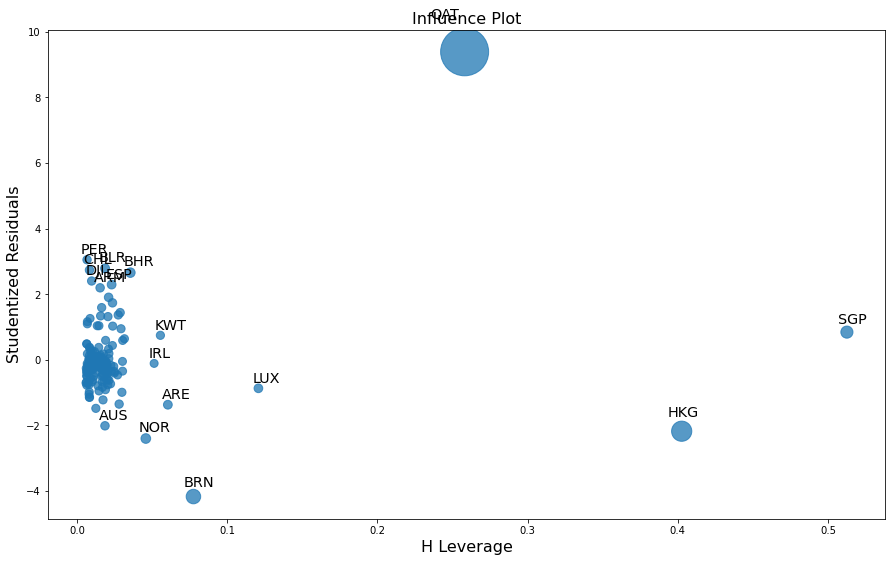

In [19]:
# Countries with higher Cook's Distance values have larger circles

fig, ax = plt.subplots(figsize=(15, 9))
sm.graphics.influence_plot(lm, ax=ax, criterion='cooks')
# plt.tight_layout()
plt.show()

# Run the model without the two outliers

In [20]:
covidanalysisminusoutliers = covidanalysis.loc[influence['cooks_d'] < 0.5]

In [21]:
lm = getlm(covidanalysisminusoutliers)

In [22]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_cases_pm   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     46.56
Date:                Fri, 12 Feb 2021   Prob (F-statistic):           5.52e-22
Time:                        10:30:22   Log-Likelihood:                -1464.8
No. Observations:                 173   AIC:                             2938.
Df Residuals:                     169   BIC:                             2950.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             44.0854    349.924      0.126      0.900    -646.700     734.870
pop_density        0.2423      0.145      1.666      0.098      -0.045       0.529
median_age        -2.5165     13.526     -0.186      0.853     -29.217      24.184
gdp_per_capita     0.0557      0.007      7.875      0.000       0.042       0.070
==============================================================================
Omnibus:                       53.262   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.935
Skew:                           1.347   Prob(JB):                     1.22e-27
Kurtosis:                       6.152   Cond. No.                     1.01e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""